In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import kahnstatspy.GSLIB as gslib
import kahnstatspy.geostats as geostats
from scipy.spatial.distance import pdist, squareform
import math

# Load UG90 Excel File

In [2]:
df = pd.read_csv("UG90 PROJECT.csv") #Create a data frame containing UG90 data called df

# Increasing the X and Y coordinates by 0.001
df_mod = df.copy()
df_mod['X'] = df['X'] + 0.001
df_mod['Y'] = df['Y'] + 0.001


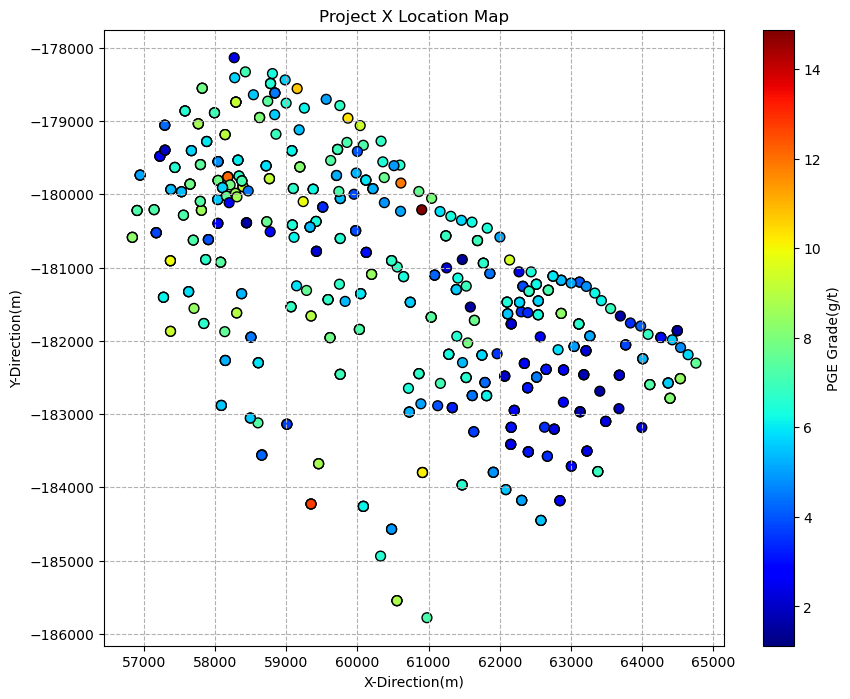

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(df_mod['X'], df_mod['Y'], c = df_mod['PGE'], s = 50, 
            edgecolors = 'k', cmap = 'jet')
cbar = plt.colorbar()
cbar.set_label("PGE Grade(g/t)", loc = 'center')
plt.title("Project X Location Map")
plt.xlabel("X-Direction(m)")
plt.ylabel("Y-Direction(m)")
plt.grid(linestyle = '--')
plt.show()

# Data Spacing

## Borehole Spacing

In [4]:
# Extracting the X and Y coordinates
coordinates = df[['X', 'Y']]

# Calculate the pairwise distances between all boreholes
distances = pdist(coordinates, metric='euclidean')

# Calculate the average distance
average_distance = distances.mean()

#Display outcome
print(f"Average Borehole Spacing: {average_distance:.2f} m") 

Average Borehole Spacing: 3242.71 m


In [5]:
# Assuming we are considering only the X and Y coordinates for 2D data spacing calculation
boreholes = df[['X', 'Y']].values.tolist()

def calculate_area(radius):
    return math.pi * radius ** 2

def count_nearby_samples(borehole, boreholes, radius):
    count = 0
    for other in boreholes:
        if other != borehole:
            distance = math.sqrt((other[0] - borehole[0])**2 + (other[1] - borehole[1])**2)
            if distance <= radius:
                count += 1
    return count

def calculate_data_spacing(boreholes, radius):
    area = calculate_area(radius)
    spacings = []
    for borehole in boreholes:
        nv = count_nearby_samples(borehole, boreholes, radius)
        if nv > 0:
            spacing = math.sqrt(area / nv)
        else:
            spacing = float('inf')  # No nearby samples
        spacings.append(spacing)
    return spacings

# Define a radius for the area around each borehole (this needs to be adjusted based on the data's scale)
radius = 3000  # Example radius, this value should be refined based on the actual scale of the data

# Calculate data spacing for each borehole
spacings = calculate_data_spacing(boreholes, radius)

# Calculate the average spacing
average_data_spacing = sum(spacings) / len(spacings) if spacings else None

average_data_spacing


324.22838099332944

# Cell declustering

In [6]:
wts, cell_sizes, dmeans = geostats.declus(df_mod,'X','Y','PGE',iminmax = 1, noff= 10, ncell=250,cmin=1,cmax=10000)

There are 570 data with:
   mean of      5.761927368421053 
   min and max  1.1238 and 14.875
   standard dev 2.198901554154939 


### Add declustering weights to data frame

In [7]:
df_mod['declus_weights'] = wts

In [8]:
df_mod.head(-10)

,BHID,X,Y,Z,DENSITY,PGE,CU,NI,PT,PD,RH,AU,declus_weights
0,WV124D0,64537.971,-182515.439,940.59,4.1604,9.6785,0.0132,0.1229,3.9519,4.9729,0.5590,0.1946,3.378704
1,WV124D1,64537.871,-182515.549,940.65,4.3021,6.9002,0.0072,0.1192,3.8498,2.3939,0.6306,0.0259,3.378704
2,WV124D2,64537.761,-182515.659,940.67,4.1150,8.4249,0.0286,0.1578,4.1353,3.5229,0.5775,0.1891,3.378704
3,WV93ID0,64758.171,-182303.839,1014.90,4.1652,7.5486,0.0112,0.1225,4.3245,2.4174,0.6668,0.1400,3.378704
4,WV94ID0,64647.281,-182189.059,1010.84,4.3862,5.7957,0.0056,0.1169,3.7544,1.4438,0.5633,0.0341,3.378704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,WQ506D0,60513.711,-179608.689,1069.26,3.9608,4.9231,0.0033,0.0872,3.3887,1.1191,0.4023,0.0131,0.672788
556,WQ508D0,59705.001,-179743.769,968.42,4.0277,6.5456,0.0069,0.1070,3.9643,2.0020,0.4571,0.1223,0.509673
557,WQ508D1,59706.791,-179742.049,968.99,3.9549,5.1630,0.0048,0.0960,3.7410,0.9261,0.4513,0.0446,0.509673
558,WQ509D0,59721.041,-179387.269,1010.66,4.0276,5.6392,0.0092,0.1026,3.5693,1.5642,0.4071,0.0986,0.666710


### Distribution of weights over deposit area

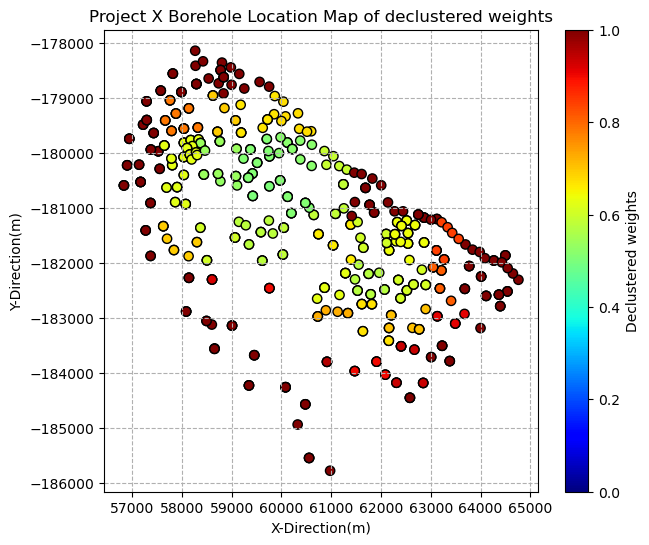

In [9]:
plt.figure(figsize=(7, 6))
plt.scatter(df_mod['X'], df_mod['Y'], c = df_mod['declus_weights'], s = 45, edgecolor = 'k', cmap = 'jet', vmin = 0, vmax = 1)
cbar = plt.colorbar()
cbar.set_label("Declustered weights", loc = 'center')
plt.title("Project X Borehole Location Map of declustered weights")
plt.xlabel("X-Direction(m)")
plt.ylabel("Y-Direction(m)")
plt.grid(ls =  '--')
plt.show()

### Comparison on Original vs Declustered mean

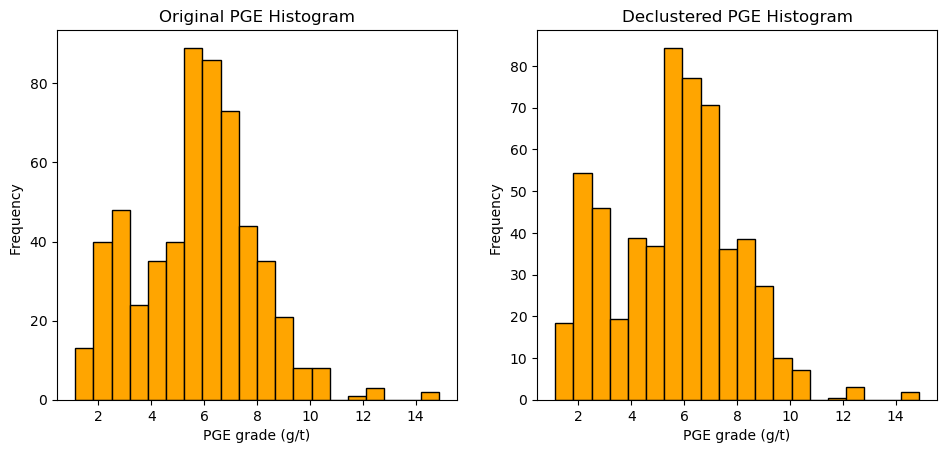

In [11]:
plt.subplot(1,2,1)
plt.hist(df_mod['PGE'], color ='orange', edgecolor = 'black', bins = 20)
plt.title('Original PGE Histogram')
plt.xlabel('PGE grade (g/t)')
plt.ylabel('Frequency  ')
#plt.grid(ls = '--')

plt.subplot(1,2,2)
plt.hist(df_mod['PGE'], color ='orange', edgecolor = 'black', bins = 20, weights= df_mod['declus_weights'])
plt.title('Declustered PGE Histogram')
plt.xlabel('PGE grade (g/t)')
plt.ylabel('Frequency  ')
#plt.grid(ls = '--')


plt.subplots_adjust(right = 1.5, hspace=0.5)
plt.show()

### Comparison of means

In [25]:
pge_mean = np.average(df_mod['PGE'].values)
pge_dmean = np.average(df_mod['PGE'].values,weights=df_mod['declus_weights'].values)

print('The PGE naive mean is ' + str(round(pge_mean,3))+'.')
print('The PGE declustered mean is ' + str(round(pge_dmean,3))+'.')
cor = (pge_mean-pge_dmean)/pge_mean
print('Correction of ' + str(round(cor,4)) +'.')

The PGE naive mean is 5.762.
The PGE declustered mean is 5.678.
Correction of 0.0146.


# Variogram Map

## Normalise the data: Nscores

In [26]:
df_mod['NPGE'],tvCv,tnsCv = geostats.nscore(df_mod,'PGE')

In [27]:
df_mod

,BHID,X,Y,Z,DENSITY,PGE,CU,NI,PT,PD,RH,AU,Weights,declus_weights,NPGE
0,WV124D0,64537.971,-182515.439,940.59,4.1604,9.6785,0.0132,0.1229,3.9519,4.9729,0.5590,0.1946,3.378704,3.378704,1.870579
1,WV124D1,64537.871,-182515.549,940.65,4.3021,6.9002,0.0072,0.1192,3.8498,2.3939,0.6306,0.0259,3.378704,3.378704,0.567793
2,WV124D2,64537.761,-182515.659,940.67,4.1150,8.4249,0.0286,0.1578,4.1353,3.5229,0.5775,0.1891,3.378704,3.378704,1.286566
3,WV93ID0,64758.171,-182303.839,1014.90,4.1652,7.5486,0.0112,0.1225,4.3245,2.4174,0.6668,0.1400,3.378704,3.378704,0.896145
4,WV94ID0,64647.281,-182189.059,1010.84,4.3862,5.7957,0.0056,0.1169,3.7544,1.4438,0.5633,0.0341,3.378704,3.378704,-0.090273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,WQ513D1,60217.521,-179924.269,1005.71,4.0264,6.0506,0.0038,0.0900,4.0151,1.5752,0.4318,0.0285,0.515751,0.515751,0.085858
566,WQ513D2,60217.431,-179924.189,1005.71,3.9012,5.2359,0.0033,0.0998,3.7575,1.0148,0.4235,0.0400,0.515751,0.515751,-0.390061
567,WQ527D0,59982.961,-179709.249,1005.80,4.0028,5.3041,0.0062,0.1011,3.5438,1.2130,0.5172,0.0301,0.515751,0.515751,-0.352369
568,WQ529D0,59951.361,-179998.889,967.06,3.7103,3.8347,0.0054,0.0698,2.6699,0.7602,0.3725,0.0322,0.515751,0.515751,-0.789492


Text(0, 0.5, 'Frequency  ')

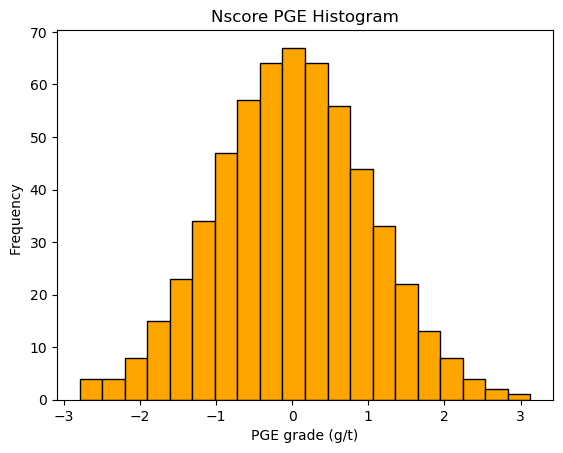

In [29]:
plt.hist(df_mod['NPGE'], color ='orange', edgecolor = 'black', bins = 20)
plt.title('Nscore PGE Histogram')
plt.xlabel('PGE grade (g/t)')
plt.ylabel('Frequency  ')

## Smooth map

In [46]:
vmap1,npmap1= geostats.varmapv(df_mod, 'X', 'Y','NPGE',tmin =-9999,
                            tmax =9999, nxlag =15 , nylag =15,
                            dxlag = 200, dylag = 200, minnp= 1,
                            isill = 1)

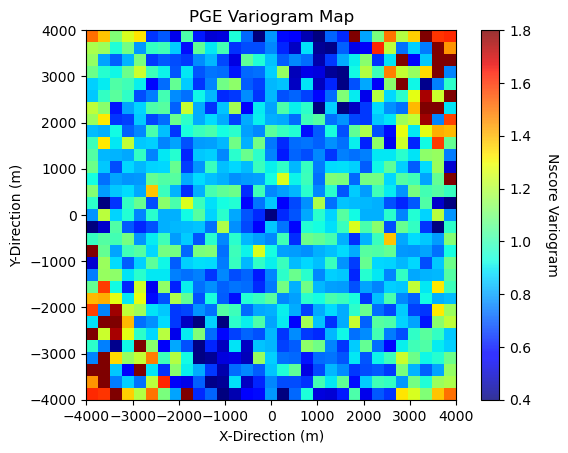

In [50]:
gslib.pixelplt_st(vmap1, -4000,4000,-4000,4000,500,0.4,1.8,'PGE Variogram Map','X-Direction (m)','Y-Direction (m)',
                  'Nscore Variogram','jet')
plt.show()